## Кластерный анализ 

In [12]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [13]:
visa_data = pd.read_csv('visa_data4.csv')
agg_data = visa_data.groupby('Country').agg({
    'Коэффициент легкости': 'mean',
    'Root_Median_Ratio': 'mean'
}).rename(columns={
    'Коэффициент легкости': 'mean_ease',
    'Root_Median_Ratio': 'mean_tourism'
}).reset_index()

agg_data['mean_ease_norm'] = (agg_data['mean_ease'] - agg_data['mean_ease'].min()) / (agg_data['mean_ease'].max() - agg_data['mean_ease'].min())
agg_data['mean_tourism_norm'] = (agg_data['mean_tourism'] - agg_data['mean_tourism'].min()) / (agg_data['mean_tourism'].max() - agg_data['mean_tourism'].min())
agg_data

C:\Users\Егор\AppData\Local\Temp\ipykernel_26896\1871354095.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  visa_data = pd.read_csv('visa_data4.csv')


,Country,mean_ease,mean_tourism,mean_ease_norm,mean_tourism_norm
0,Afghanistan,0.197917,0.001000,0.000000,0.000000
1,Albania,0.645833,0.665699,0.558442,0.665364
2,Algeria,0.230208,0.530978,0.040260,0.530509
3,Andorra,0.600000,0.723820,0.501299,0.723544
4,Angola,0.611979,0.442537,0.516234,0.441979
...,...,...,...,...,...
188,Venezuela,0.491667,0.502569,0.366234,0.502071
189,Vietnam,0.518750,0.696005,0.400000,0.695701
190,Yemen,0.216667,0.495918,0.023377,0.495413
191,Zambia,0.725000,0.516504,0.657143,0.516020


## Используем локтевой метод для опредления оптимального кол-ва кластеров

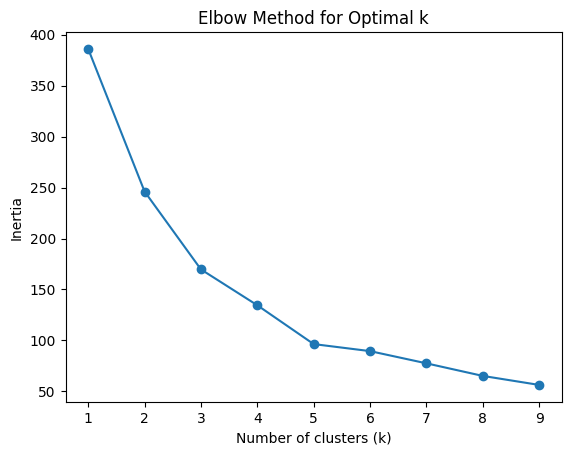

In [14]:
X = agg_data[['mean_ease_norm', 'mean_tourism_norm']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=5, random_state=42)
agg_data['cluster'] = kmeans.fit_predict(X_scaled)

In [15]:
score = silhouette_score(X_scaled, agg_data['cluster'])
print(f'Silhouette Score: {score:.2f}')

Silhouette Score: 0.39


## присвоение алиасов и визуализация

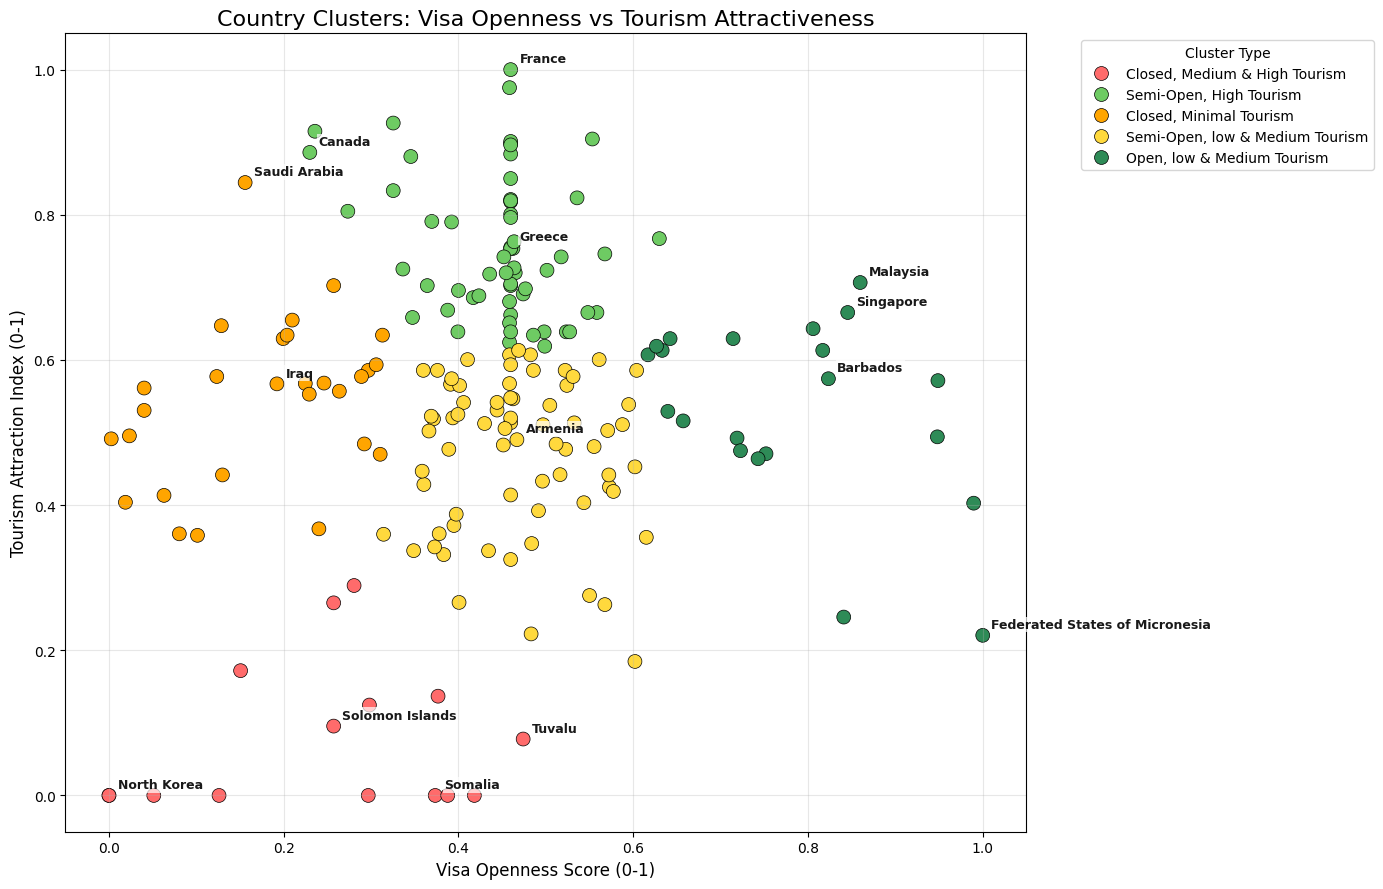

In [16]:
cluster_names = {
    0: 'Closed, Minimal Tourism',
    1: 'Closed, Medium & High Tourism',
    2: 'Semi-Open, low & Medium Tourism',
    3: 'Semi-Open, High Tourism',
    4: 'Open, low & Medium Tourism'
}

palette = {
    'Closed, Minimal Tourism': '#FFA500',
    'Closed, Medium & High Tourism': '#FF6B6B',
    'Semi-Open, low & Medium Tourism': '#FFD93D',
    'Semi-Open, High Tourism': '#6ECB63',
    'Open, low & Medium Tourism': '#2E8B57'
}

agg_data['cluster_name'] = agg_data['cluster'].map(cluster_names)

plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=agg_data,
    x='mean_ease_norm',
    y='mean_tourism_norm',
    hue='cluster_name',
    palette=palette,
    s=100,
    edgecolor='black',
    linewidth=0.5
)

centroids = kmeans.cluster_centers_
representative_countries = []

for cluster_id in range(5):
    cluster_points = X_scaled[agg_data['cluster'] == cluster_id]
    cluster_indices = agg_data[agg_data['cluster'] == cluster_id].index
    distances = np.linalg.norm(cluster_points - centroids[cluster_id], axis=1)
    closest_idx = cluster_indices[np.argmin(distances)]
    representative_countries.append(agg_data.loc[closest_idx])

special_countries = [
    'Singapore', 'Somalia', 'France',
    'North Korea', 'Federated States of Micronesia',
    'Saudi Arabia', 'Tuvalu', 'Canada', 'Malaysia'
]

for row in representative_countries + [agg_data[agg_data['Country'] == c].iloc[0] for c in special_countries if c in agg_data['Country'].values]:
    plt.text(
        row['mean_ease_norm'] + 0.01,
        row['mean_tourism_norm'] + 0.01,
        row['Country'],
        fontsize=9,
        alpha=0.9,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

plt.title('Country Clusters: Visa Openness vs Tourism Attractiveness', fontsize=16)
plt.xlabel('Visa Openness Score (0-1)', fontsize=12)
plt.ylabel('Tourism Attraction Index (0-1)', fontsize=12)
plt.legend(title='Cluster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
